# Lab 5 Tutorial: Data engineering pipelines

In [1]:
# Global imports and settings
from preamble import *
%matplotlib inline

## Building Pipelines
* In scikit-learn, a `pipeline` combines multiple processing _steps_ in a single estimator
* All but the last step should be transformer (have a `transform` method)
    * The last step can be a transformer too (e.g. Scaler+PCA)
* It has a `fit`, `predict`, and `score` method, just like any other learning algorithm
* Pipelines are built as a list of steps, which are (name, algorithm) tuples
    * The name can be anything you want, but can't contain `'__'`
    * We use `'__'` to refer to the hyperparameters, e.g. `svm__C`
* Let's build, train, and score a `MinMaxScaler` + `LinearSVC` pipeline:

``` python
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", LinearSVC())])
pipe.fit(X_train, y_train).score(X_test, y_test)
```

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", LinearSVC())])

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    random_state=1)
pipe.fit(X_train, y_train)
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


* Now with cross-validation:
``` python
scores = cross_val_score(pipe, cancer.data, cancer.target)
```

In [3]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe, cancer.data, cancer.target)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [0.982 0.974 0.965 0.965 0.991]
Average cross-validation score: 0.98


* We can retrieve the trained SVM by querying the right step indices
``` python
pipe.steps[1][1]
```

In [4]:
pipe.fit(X_train, y_train)
print("SVM component: {}".format(pipe.steps[1][1]))

SVM component: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


* Or we can use the `named_steps` dictionary
``` python
pipe.named_steps['svm']
```

In [5]:
print("SVM component: {}".format(pipe.named_steps['svm']))

SVM component: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


* When you don't need specific names for specific steps, you can use `make_pipeline`
    * Assigns names to steps automatically
``` python
pipe_short = make_pipeline(MinMaxScaler(), LinearSVC(C=100))
print("Pipeline steps:\n{}".format(pipe_short.steps))
```

In [6]:
from sklearn.pipeline import make_pipeline
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), LinearSVC(C=100))
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('linearsvc', LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))]


Visualization of a pipeline `fit` and `predict`

<img src="../images/07_pipelines.png" alt="ml" style="width: 700px;"/>

### Using Pipelines in Grid-searches
* We can use the pipeline as a single estimator in `cross_val_score` or `GridSearchCV`
* To define a grid, refer to the hyperparameters of the steps
    * Step `svm`, parameter `C` becomes `svm__C`

In [7]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [8]:
from sklearn import pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pipe = pipeline.Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.97
Test set score: 0.97
Best parameters: {'svm__C': 10, 'svm__gamma': 1}


* When we request the best estimator of the grid search, we'll get the best pipeline
``` python
grid.best_estimator_
```

In [9]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svm',
                 SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=1, kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)


* And we can drill down to individual components and their properties
``` python
grid.best_estimator_.named_steps["svm"]
```

In [10]:
# Get the SVM
print("SVM step:\n{}".format(
      grid.best_estimator_.named_steps["svm"]))

SVM step:
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [11]:
# Get the SVM dual coefficients (support vector weights)
print("SVM support vector coefficients:\n{}".format(
      grid.best_estimator_.named_steps["svm"].dual_coef_))

SVM support vector coefficients:
[[ -1.392  -4.069  -0.435  -0.7    -5.865  -0.414  -2.814 -10.    -10.
   -3.418  -7.908  -0.169  -4.299  -1.137  -2.214  -0.19  -10.     -7.128
  -10.     -0.522  -3.766  -0.012  -1.159 -10.     -0.513  -0.712 -10.
   -1.501 -10.     10.      1.995   0.909   0.919   2.897   0.399  10.
    9.811   0.412  10.     10.     10.      5.415   0.83    2.593   1.371
   10.      0.279   1.555   6.589   1.487  10.      1.156   0.391   2.663
    1.277   0.651   1.841   2.395   2.504]]


### Grid-searching preprocessing steps and model parameters
* We can use grid search to optimize the hyperparameters of our preprocessing steps and learning algorithms at the same time
* Consider the following pipeline:
    - `StandardScaler`, without hyperparameters
    - `PolynomialFeatures`, with the max. _degree_ of polynomials
    - `Ridge` regression, with L2 regularization parameter _alpha_

In [12]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)
from sklearn.preprocessing import PolynomialFeatures
pipe = pipeline.make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

* We don't know the optimal polynomial degree or alpha value, so we use a grid search (or random search) to find the optimal values
``` python
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=1)
grid.fit(X_train, y_train)
```

In [13]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
# Note: I had to use n_jobs=1. (n_jobs=-1 stalls on my machine)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=1)
grid.fit(X_train, y_train);

* Visualing the $R^2$ results as a heatmap:

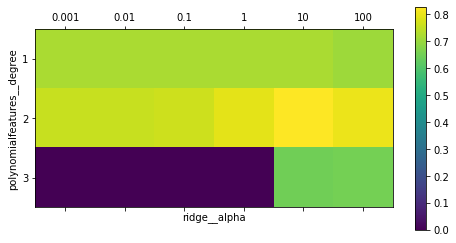

In [14]:
import matplotlib.pyplot as plt

plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
            vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
           param_grid['polynomialfeatures__degree'])

plt.colorbar();

* Here, degree-2 polynomials help (but degree-3 ones don't), and tuning the alpha parameter helps as well.
* Not using the polynomial features leads to suboptimal results (see the results for degree 1)

In [15]:
print("Best parameters: {}".format(grid.best_params_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
Test-set score: 0.77


### FeatureUnions
- Sometimes you want to apply multiple preprocessing techniques and use the _combined_ produced features
- Simply appending the produced features is called a `FeatureJoin`
- Example: Apply both PCA and feature selection, and run an SVM on both

In [16]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

iris = load_iris()

X, y = iris.data, iris.target

# This dataset is way too high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Maybe some original features where good, too?
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)
print("Combined space has", X_features.shape[1], "features")

svm = SVC(kernel="linear")

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("svm", svm)])

param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  svm__C=[0.1, 1, 10])

grid_search = GridSearchCV(pipeline, param_grid=param_grid)
grid_search.fit(X, y)
print(grid_search.best_estimator_)

Combined space has 3 features
Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pca',
                                                 PCA(copy=True,
                                                     iterated_power='auto',
                                                     n_components=3,
                                                     random_state=None,
                                                     svd_solver='auto', tol=0.0,
                                                     whiten=False)),
                                                ('univ_select',
                                                 SelectKBest(k=1,
                                                             score_func=<function f_classif at 0x123dfe2f0>))],
                              transformer_weights=None, verbose=False)),
                ('svm',
                 SVC(C=10, break_ties=False, cache

### ColumnTransformer
- A pipeline applies a transformer on _all_ columns
    - If your dataset has both numeric and categorical features, you often want to apply different techniques on each
    - You _could_ manually split up the dataset, and then feature-join the processed features (tedious)
- `ColumnTransformer` allows you to specify on which columns a preprocessor has to be run
    - Either by specifying the feature names, indices, or a binary mask
- You can include multiple transformers in a ColumnTransformer
    - In the end the results will be feature-joined
    - Hence, the order of the features will change!
        The features of the last transformer will be at the end
- Each transformer can be a pipeline
    - Handy if you need to apply multiple preprocessing steps on a set of features
    - E.g. use a ColumnTransformer with one sub-pipeline for numerical features and one for categorical features.
- In the end, the columntransformer can again be included as part of a pipeline
    - E.g. to add a classfier and include the whole pipeline in a grid search

Example: Handle a dataset (Titanic) with both categorical an numeric features
- Numeric features: impute missing values and scale
- Categorical features: Impute missing values and apply one-hot-encoding
- Finally, run an SVM

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

np.random.seed(0)

# Load data from https://www.openml.org/d/40945
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

# Alternatively X and y can be obtained directly from the frame attribute:
# X = titanic.frame.drop('survived', axis=1)
# y = titanic.frame['survived']

# We will train our classifier with the following features:
# Numeric Features:
# - age: float.
# - fare: float.
# Categorical Features:
# - embarked: categories encoded as strings {'C', 'S', 'Q'}.
# - sex: categories encoded as strings {'female', 'male'}.
# - pclass: ordinal integers {1, 2, 3}.

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['age', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.790


You can again run optimize any of the hyperparameters (preprocessing-related ones included) in a grid search

In [18]:
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search.fit(X_train, y_train)

print(("best logistic regression from grid search: %.3f"
       % grid_search.score(X_test, y_test)))

best logistic regression from grid search: 0.798
